## EDA template

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw_df = pd.read_csv('data/Train.zip')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1. Data Analysis
#### Meta data
* How many samples and features?
* What features are numeric vs. categorical

#### Data
* Inconsistent value types
* Missing values
* Zero values
* Incorrect values: sold before manufactured

In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null int64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null object
saledate                    401125 non-null object
fiModelDesc                 401125 non-null object
fiBaseModel                 401125 non-null object
fiSecondaryDesc             263934 non-null object
fiModelSeries               56908 non-null object
fiModelDescriptor           71919 non-null object
ProductSize                 190350 non-null object
fiProductClassDesc          401125 non-null object
state                       4

In [4]:
# pp.ProfileReport(raw_df)

## Subsample for speed

In [5]:
raw_df = raw_df[::20]  
# or use pd.sample()

In [6]:
raw_df.reset_index(inplace=True)
raw_df.head()

,index,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,20,1139311,41000,1014135,8867,121,3.0,2000,3259.0,Medium,...,32 inch,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
2,40,1139412,39000,108090,1088,121,3.0,2006,1125.0,Medium,...,None or Unspecified,None or Unspecified,Hydraulic,Yes,Triple,NaN,NaN,NaN,NaN,NaN
3,60,1139464,51000,882909,3783,121,3.0,2001,9052.0,High,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
4,80,1139513,67000,1029569,14411,121,3.0,2005,8281.0,Medium,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional


## Plotting

In [7]:
# pd.plotting.scatter_matrix(raw_df)
# better use seaborn pairplot, see next cell

In [8]:
# sns.pairplot(raw_df)

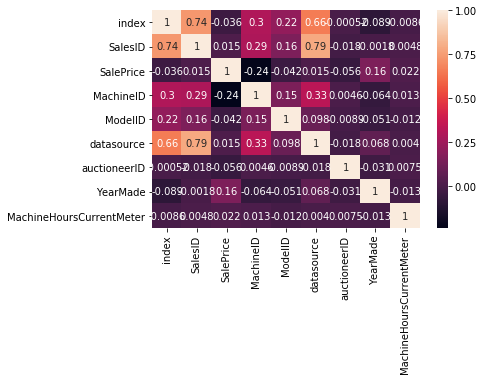

In [9]:
# Useful to get actual correlation numbers
sns.heatmap(raw_df.corr(), annot=True)

In [10]:
# plt.scatter(raw_df['YearMade'], dt.date2num(pd.to_datetime(raw_df['saledate'])))

# 2. Data Cleaning and Preparation
## 2.1 Dates to numerical

In [11]:
# getting correlations with dates by using date2num
import matplotlib.dates as dt

In [12]:
datetime = pd.to_datetime(raw_df['saledate'])

In [13]:
dateNum = dt.date2num(pd.to_datetime(raw_df['saledate']))

In [14]:
len(dateNum)

20057

In [15]:
np.argwhere(np.isnan(dateNum))

array([], shape=(0, 1), dtype=int64)

## 2.2 Fill missing values

Replace the implausible values of YearMade by using KNN

### Output
X_all: all rows,  cols:ModelID, YearMade (with bad values replaced)

### Local
KNN training: 
X_KNN: rows: YearMade > 1500     cols: ModelID, saledate_num
y_KNN: YearMade

In [16]:
from sklearn.neighbors import KNeighborsRegressor

In [17]:
X_all = raw_df[['ModelID','YearMade']].copy()

In [18]:
X_all.describe()

,ModelID,YearMade
count,20057.000000,20057.000000
mean,6886.596799,1896.220621
std,6241.768797,295.761027
min,28.000000,1000.000000
25%,3255.000000,1984.000000
50%,4604.000000,1995.000000
75%,8714.000000,2000.000000
max,37198.000000,2011.000000


In [19]:
X_all.loc[:,'saledate_num'] = pd.Series(dateNum)
X_all.describe()

,ModelID,YearMade,saledate_num
count,20057.000000,20057.000000,20057.000000
mean,6886.596799,1896.220621,731791.787057
std,6241.768797,295.761027,2101.330960
min,28.000000,1000.000000,726133.000000
25%,3255.000000,1984.000000,730397.000000
50%,4604.000000,1995.000000,732388.000000
75%,8714.000000,2000.000000,733485.000000
max,37198.000000,2011.000000,734501.000000


In [20]:
X_KNN = X_all[X_all['YearMade']>1500].copy()

In [21]:
y_KNN = X_KNN['YearMade']
X_KNN.drop('YearMade',axis=1,inplace=True)
X_KNN.head(1)

,ModelID,saledate_num
0,3157,732631.0


In [22]:
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_KNN, y_KNN) 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform')

In [23]:
X_to_fill = X_all[X_all['YearMade'] <= 1500].copy()
X_to_fill.drop('YearMade',axis=1,inplace=True)

In [24]:
len(X_to_fill.index)

1968

In [25]:
year_predicted = neigh.predict(X_to_fill)

In [26]:
len(X_to_fill)

1968

In [27]:
year_predicted

array([1994. , 2000. , 1991. , ..., 2000.5, 1999. , 2006. ])

In [28]:
# X_all['YearMade'][X_all['YearMade'] <= 1000] = year_predicted 
X_all.loc[X_all['YearMade'] <= 1000, 'YearMade'] = year_predicted

In [29]:
X_all.head(2)

,ModelID,YearMade,saledate_num
0,3157,2004.0,732631.0
1,8867,2000.0,732449.0


In [30]:
X_all.loc[X_all['YearMade'] <= 1000].head()

,ModelID,YearMade,saledate_num


In [31]:
len(X_all.index)

20057

- we replaced all the implausible YearMade values with plausible ones. No '1000's anymore. 

# 3 Linear Regression

In [32]:
import statsmodels.api as sm

In [35]:
X_OLS = X_all
y_OLS = raw_df['SalePrice']

In [37]:
model = sm.OLS(y_OLS, X_OLS)
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                 1.335e+04
Date:                Wed, 12 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:12:20   Log-Likelihood:            -2.2928e+05
No. Observations:               20057   AIC:                         4.586e+05
Df Residuals:                   20054   BIC:                         4.586e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
ModelID         -0.3114      0.026    -12.147      0.000      -0.362      -0.261
YearMade       737.1682     21.446     34.373      0.000     695.131     779.205
saledate_num    -1.9631      0.058    -33.620      0.000      -2.078      -1.849
==============================================================================
Omnibus:                     5360.144   Durbin-Watson:                   0.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12564.475
Skew:                           1.509   Prob(JB):                         0.00
Kurtosis:                       5.433   Cond. No.                     9.97e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.97e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
X_OLS.head()

,ModelID,YearMade,saledate_num
0,3157,2004.0,732631.0
1,8867,2000.0,732449.0
2,1088,2006.0,733583.0
3,3783,2001.0,732519.0
4,14411,2005.0,734255.0


## Test Score

In [ ]:
X_test = pd.read_csv('data/Test.zip')

In [ ]:
df_sol = pd.read_csv("data/do_not_open/test_soln.csv.zip")

dateNum = dt.date2num(pd.to_datetime(X_test['saledate']))
X_test['saledate_num'] = pd.Series(dateNum)
X_test.head()

In [ ]:
def score(self, predictions):
        log_diff = np.log(predictions+1) - np.log(self+1)
        return np.sqrt(np.mean(log_diff**2))

In [ ]:
X_test = X_test[['ModelID','YearMade','saledate_num']]

In [ ]:
# X_train = X_test[X_all['YearMade']>1000]
# y = X_train['YearMade']
# X_train.drop('YearMade',axis=1,inplace=True)
# X_train.head()

In [ ]:
X_t_to_fill = X_test[X_test['YearMade'] <= 1500]
X_t_to_fill.drop('YearMade',axis=1,inplace=True)

year_predicted_t = neigh.predict(X_t_to_fill)
# X_test.loc[X_test['YearMade'] <= 1000, 'YearMade'] = pd.DataFrame(year_predicted_t)
X_test['YearMade'][X_test['YearMade'] <= 1000] = year_predicted_t

In [ ]:
year_predicted_t

In [ ]:
X_test.head()

In [ ]:
test_prediction = model.predict(X_test)

In [ ]:
rmsle = score(df_sol["SalePrice"], test_prediction)
rmsle

In [ ]:
X.columns